In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import bartlett
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings 
warnings.filterwarnings("ignore")
plt.rcParams['font.family'] = 'Malgun Gothic'
# df = pd.read_csv('../csv&excel/feature_select_nolog.csv')
df = pd.read_csv('../csv&excel/feature_select_logdone.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [2]:
## 장르 get_dummies 후 장르 컬럼 삭제
dummies_genre = pd.get_dummies(df['장르'], prefix='장르')
df = pd.concat([df,dummies_genre], axis=1)
df.drop(['장르'],axis=1,inplace=True)

In [3]:
## logdone파일 시 사용
from sklearn.model_selection import train_test_split
labels = df["타겟"]
features = df.drop(columns=['영화명', '개봉일', '타겟'], axis=1)
X_train_MM, X_test_MM, Y_train, Y_test = train_test_split(features,labels, test_size=0.3, random_state=156, stratify=labels)

In [4]:
# nolog파일 시 사용
# from sklearn.model_selection import train_test_split
# labels = df["타겟"]
# features = df.drop(columns=['영화명', '개봉일', '타겟'], axis=1)
# X_train, X_test, Y_train, Y_test = train_test_split(features,labels, test_size=0.3, random_state=156, stratify=labels)
# ----------------------------------------------------------------------------------
## minmaxscaler
# from sklearn.preprocessing import MinMaxScaler
# scaler_MM = MinMaxScaler()
# scaler_MM.fit(X_train)
# data_scaled_MM = scaler_MM.transform(X_train)
# X_train_MM = pd.DataFrame(data = data_scaled_MM, columns=X_train.columns)
# scaler_MM.fit(X_train)
# data_scaled_MM_1 = scaler_MM.transform(X_test)
# X_test_MM = pd.DataFrame(data = data_scaled_MM_1, columns=X_test.columns)
## ------------------------------------------------------------------------------
# standardscaler
# from sklearn.preprocessing import StandardScaler
# scaler_St = StandardScaler()
# scaler_St.fit(X_train)
# data_scaled_MM = scaler_St.transform(X_train)
# X_train_MM = pd.DataFrame(data = data_scaled_MM, columns=X_train.columns)
# scaler_St.fit(X_train)
# data_scaled_MM_1 = scaler_St.transform(X_test)
# X_test_MM = pd.DataFrame(data = data_scaled_MM_1, columns=X_test.columns)

### SelectKBest

In [5]:
#필터방법(SelectKBest)
from sklearn.feature_selection import SelectKBest, f_classif, chi2

# Select the top 10 features based on ANOVA F-value
selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(X_train_MM, Y_train)

# Get selected feature names
mask = selector.get_support()
selected_features = X_train_MM.columns[mask]

# Create DataFrame with selected features and their p-values
selected_result_1 = pd.DataFrame({'feature': selected_features,
                                'pvalue': selector.pvalues_[mask]})
selected_result_1

,feature,pvalue
0,로그 전국스크린수,0.000024
1,로그 전국매출액,0.042544
2,로그 전국관객수,0.009103
3,로그 서울매출액,0.008524
4,로그 서울관객수,0.012766
5,로그 수정전국매출액,0.005681
6,로그 개봉일관객수,0.007125
7,로그 개봉일매출액,0.003717
8,로그 배우가중치,0.007703
9,로그 감독가중치,0.011298


### T-test

In [6]:
# T-test
# 등분산성 확인 전 레이블 부착
Y_train_t = Y_train.reset_index()
X_train_MM_t = X_train_MM.reset_index()

Y_train_t.drop(columns=['index'], axis=1, inplace=True)
X_train_MM_t.drop(columns=['index'], axis=1, inplace=True)

x_등분산 = pd.concat([X_train_MM_t, Y_train_t], axis=1)
# H가 1인 경우 이분산성 / H가 0인 경우 등분산

def bartlett_test_2(col, p_value = 0.05, H = 1):
    list= []
    for i in col:
        T, p_val =bartlett(x_등분산[x_등분산['타겟']==1][i], x_등분산[x_등분산['타겟']==0][i]) 
        list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    if H == 1:
        a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
        return a
    else:
        a = list[(list['p_value'] >= p_value)][['변수', 'p_value']].sort_values('p_value')
        return a
# 이분산성 변수
x_hetero = bartlett_test_2(X_train_MM.columns, H = 1)
# 등분산성 변수
x_homo = bartlett_test_2(X_train_MM.columns, H = 0)
set_이분산 = set(x_hetero["변수"])
set_등분산 = set(x_homo["변수"])

In [7]:
# 2) t_test
def t_test_2(col, col_h0, col_h1, p_value = 0.05):
    list= []
    for i in col:
        if (col_h0['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(x_등분산[x_등분산['타겟']==1][i], x_등분산[x_등분산['타겟']==0][i], equal_var=True) # 등분산성 : wald t-test
            list.append([i, p_val])
        elif (col_h1['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(x_등분산[x_등분산['타겟']==1][i], x_등분산[x_등분산['타겟']==0][i], equal_var=False) # 이분산성 : welch’s t-test
            list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
    return a

x_ttest = t_test_2(X_train_MM.columns, x_homo, x_hetero, p_value=0.05)
print("유의한 피쳐 수 :", len(x_ttest))
selected_result_2 = x_ttest.sort_values(by="변수", ascending=True)
selected_result_2

유의한 피쳐 수 : 10


,변수,p_value
15,로그 감독가중치,0.011838
11,로그 개봉일관객수,0.007125
12,로그 개봉일매출액,0.003717
14,로그 배우가중치,0.007958
9,로그 서울관객수,0.012766
8,로그 서울매출액,0.008524
10,로그 수정전국매출액,0.005681
7,로그 전국관객수,0.009103
6,로그 전국매출액,0.048777
5,로그 전국스크린수,0.000024


### Stepwise

In [8]:
# stepwise
def stepwise_feature_selection(feature, target, variables):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    import warnings
    import pandas as pd
    warnings.filterwarnings("ignore")
    
    y = target ## 반응 변수

    selected_variables = [] ## 선택된 변수들
    sl_enter = 0.1
    sl_remove = 0.1
    
    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) ## 변수의 p-value
        ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
        ## 선형 모형을 적합한다.
        for col in remainder: 
            X = feature[selected_variables+[col]]
            X = sm.add_constant(X)
            model = sm.Logit(y,X).fit(disp=0)
            pval[col] = model.pvalues[col]
    
        min_pval = pval.min()
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
            selected_variables.append(pval.idxmin())
            ## 선택된 변수들에대해서
            ## 어떤 변수를 제거할지 고른다.
            while len(selected_variables) > 0:
                selected_X = feature[selected_variables]
                selected_X = sm.add_constant(selected_X)
                selected_pval = sm.Logit(y,selected_X).fit(disp=0).pvalues[1:]
                max_pval = selected_pval.max()
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                    remove_variable = selected_pval.idxmax()
                    selected_variables.remove(remove_variable)
                else:
                    break
            
            step += 1
            steps.append(step)
            presudo_r_squared = sm.Logit(y,sm.add_constant(feature[selected_variables])).fit(disp=0).prsquared
            r_squared.append(presudo_r_squared)
            sv_per_step.append(selected_variables.copy())
        else:
            break
    
    return selected_variables
    
selected_result_3 = stepwise_feature_selection(X_train_MM, Y_train, X_train_MM.columns.tolist())
selected_result_3

['로그 전국스크린수', '로그 개봉일매출비율', '장르_애니메이션', '로그 개봉일매출액', '로그 개봉일관객수']

In [9]:
lasso_model = LogisticRegression()
param_grid = {'penalty' : ['l1'], 
                'C' : np.logspace(-4, 4, 20),
                'solver' : ['liblinear', 'saga']}

grid_search = GridSearchCV(lasso_model, param_grid=param_grid, return_train_score=True, cv=5)
grid_search.fit(X_train_MM, Y_train)

df_grid = pd.DataFrame(grid_search.cv_results_)
df_grid = df_grid.sort_values(by=['rank_test_score'], ascending=True)
df_grid[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']]
print('GridSearchCV 최적 파라미터:', grid_search.best_params_)
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_search.best_score_))

GridSearchCV 최적 파라미터: {'C': 0.23357214690901212, 'penalty': 'l1', 'solver': 'saga'}
GridSearchCV 최고 정확도:0.5557


In [10]:
# lasso_best = LogisticRegression(C=0.5, penalty='l1', solver='liblinear').fit(X_train_MM, Y_train)
lasso_best = LogisticRegression(**grid_search.best_params_).fit(X_train_MM, Y_train)
selected_result_4 = pd.DataFrame()
selected_result_4['feature'] = X_train_MM.columns
selected_result_4['coef'] = lasso_best.coef_[0]
selected_result_4.drop(selected_result_4[selected_result_4['coef']==0].index, inplace=True)
selected_result_4

,feature,coef
1,등급,-0.046361
2,국내배급사,-0.082471
3,상장배급사,0.044164
5,로그 전국스크린수,-0.259208
6,로그 전국매출액,0.044429
8,로그 서울매출액,0.015121
10,로그 수정전국매출액,-0.082447
11,로그 개봉일관객수,-0.032700
13,로그 개봉일매출비율,0.095083
14,로그 배우가중치,-0.086328


In [11]:
list_1 = list(selected_result_1['feature'])
list_2 = list(selected_result_2['변수'])
list_3 = list(selected_result_3)
list_4 = list(selected_result_4['feature'])
list_col_all = df.columns

In [12]:
def func_1(x):
    if x in list_1:
        return 1
    else:
        return 0

def func_2(x):
    if x in list_2:
        return 1
    else:
        return 0

def func_3(x):
    if x in list_3:
        return 1
    else:
        return 0
    
def func_4(x):
    if x in list_4:
        return 1
    else:
        return 0

In [13]:
feature_counts = pd.DataFrame()
feature_counts['feature'] = list_col_all
feature_counts['1'] = list_col_all.map(func_1)
feature_counts['2'] = list_col_all.map(func_2)
feature_counts['3'] = list_col_all.map(func_3)
feature_counts['4'] = list_col_all.map(func_4)

feature_counts["total"] = feature_counts["1"]+feature_counts["2"]+feature_counts["3"]+feature_counts["4"]
feature_final = feature_counts[feature_counts["total"]>=2]
list_feature_final = list(feature_final["feature"])
print("선택된 피쳐수 :", len(list_feature_final))
feature_final

선택된 피쳐수 : 12


,feature,1,2,3,4,total
7,로그 전국스크린수,1,1,1,1,4
8,로그 전국매출액,1,1,0,1,3
9,로그 전국관객수,1,1,0,0,2
10,로그 서울매출액,1,1,0,1,3
11,로그 서울관객수,1,1,0,0,2
12,로그 수정전국매출액,1,1,0,1,3
13,로그 개봉일관객수,1,1,1,1,4
14,로그 개봉일매출액,1,1,1,0,3
15,로그 개봉일매출비율,0,0,1,1,2
16,로그 배우가중치,1,1,0,1,3


In [14]:
select_final = []
for i in feature_final.index:
    if feature_final.loc[i, "total"] >= 2:
        select_final.append(feature_final.loc[i, 'feature'])
select_final


['로그 전국스크린수',
 '로그 전국매출액',
 '로그 전국관객수',
 '로그 서울매출액',
 '로그 서울관객수',
 '로그 수정전국매출액',
 '로그 개봉일관객수',
 '로그 개봉일매출액',
 '로그 개봉일매출비율',
 '로그 배우가중치',
 '로그 감독가중치',
 '장르_애니메이션']

In [15]:
X_train = X_train_MM[select_final]
X_test = X_test_MM[select_final]
X_train

,로그 전국스크린수,로그 전국매출액,로그 전국관객수,로그 서울매출액,로그 서울관객수,로그 수정전국매출액,로그 개봉일관객수,로그 개봉일매출액,로그 개봉일매출비율,로그 배우가중치,로그 감독가중치,장르_애니메이션
380,7.010312,41.644677,14.183587,21.871901,12.773756,4.803316,11.156493,20.174911,3.335770,-0.597837,-2.995732,0
834,6.276643,40.134315,12.795403,20.291965,11.331152,3.292953,8.799662,17.668895,0.587787,-1.791759,-3.401197,1
779,6.028279,40.290251,12.969541,20.423422,11.477568,3.448889,10.832754,19.666731,2.862201,-1.321756,-3.401197,0
19,7.201916,43.554006,16.145108,23.961958,14.940127,6.712644,12.332815,21.303319,4.213608,2.772589,1.098612,0
48,7.303170,43.166672,15.743877,23.460554,14.419784,6.325310,12.644463,21.580613,4.223910,0.832909,-1.609438,0
...,...,...,...,...,...,...,...,...,...,...,...,...
465,5.758902,41.237146,13.910516,21.630941,12.668907,4.395785,10.190957,19.074377,3.000720,0.000000,-2.302585,0
21,6.841615,43.596944,16.112921,24.050091,14.946053,6.760194,11.612563,20.449080,2.944439,-0.916291,-0.916291,0
735,5.945421,40.331975,13.078186,20.496196,11.606534,3.490614,10.198766,18.962095,0.993252,-0.693147,-3.401197,1
454,6.091310,41.256782,13.938293,21.845131,12.890931,4.415420,10.786738,19.664747,3.157000,-0.510826,-2.302585,0


In [16]:
X_train.to_csv('../csv&excel/X_train.csv', index=0)
X_test.to_csv('../csv&excel/X_test.csv', index=0)
Y_train.to_csv('../csv&excel/Y_train.csv', index=0)
Y_test.to_csv('../csv&excel/Y_test.csv', index=0)

<AxesSubplot: >

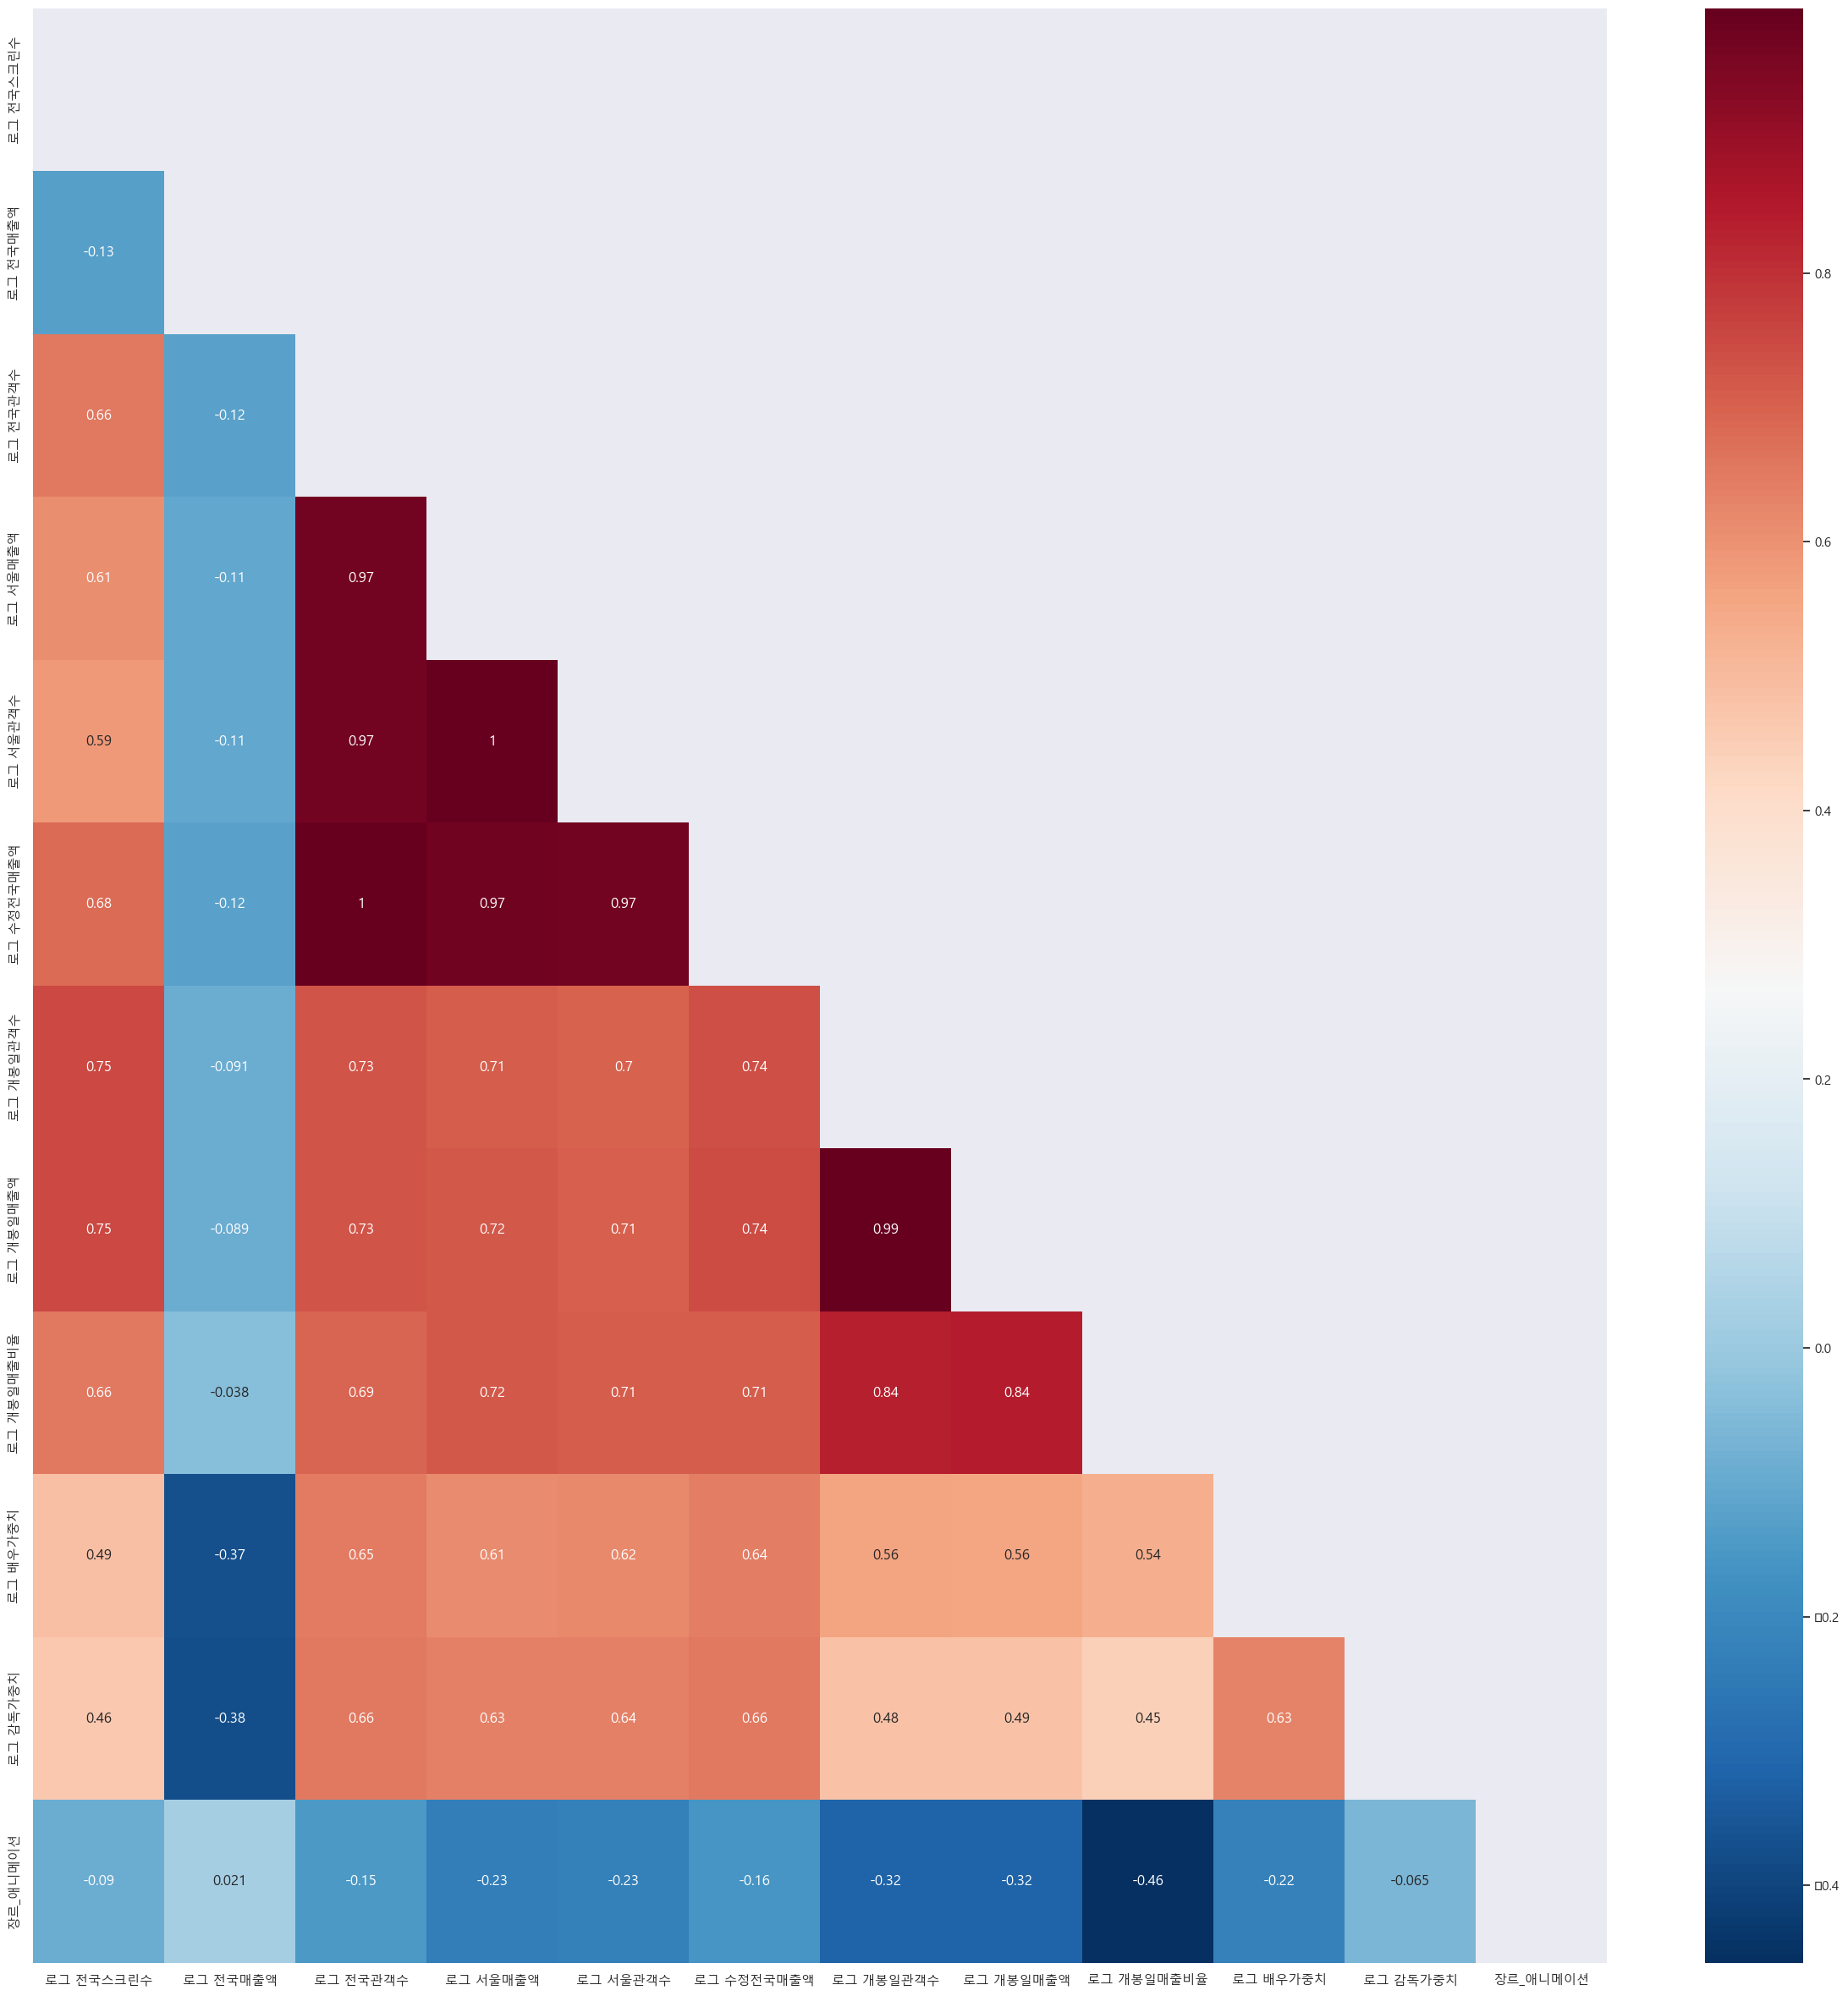

In [17]:
## 선택된 변수들의 상관관계 확인
df_cor = X_train.corr(method='pearson')

sns.set(rc = {'figure.figsize':(30,30)})
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.heatmap(df_cor, xticklabels=df_cor.columns, yticklabels=df_cor.columns, cmap='RdBu_r', annot=True, mask=np.triu(df_cor))

In [18]:
## 다중 공선성 확인
vif_IQR_drop = pd.DataFrame()

# VIF 값과 각 Feature 이름에 대해 설정
vif_IQR_drop["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif_IQR_drop["features"] = X_train.columns 

# VIF 값이 높은 순으로 정렬
vif_IQR_drop = vif_IQR_drop.sort_values(by="VIF Factor", ascending=False)
vif_IQR_drop = vif_IQR_drop.reset_index().drop(columns='index')
vif_IQR_drop

,VIF Factor,features
0,132933.256443,로그 서울매출액
1,82742.991801,로그 개봉일매출액
2,55221.546869,로그 서울관객수
3,25826.867903,로그 개봉일관객수
4,12737.394682,로그 전국관객수
5,1220.732833,로그 수정전국매출액
6,644.629970,로그 전국스크린수
7,91.416666,로그 전국매출액
8,50.724100,로그 개봉일매출비율
9,22.196906,로그 감독가중치
